# Projeto 02 – Notebook 2: Clustering com K-Means

## Introdução

Este notebook visa apresentar o trabalho desenvolvido pelo Grupo 3  composto por Tiago Sousa (20735), Rodrigo Castro (23143), Rogério Gomes (27216), Paulo Costa (29851) e Lais Carvalho (51067)  no âmbito do projeto prático da disciplina de Inteligência Artificial.

O presente projeto tem como objetivo aplicar técnicas de Aprendizagem Não Supervisionada, mais concretamente o algoritmo K-Means, para identificar padrões e agrupamentos naturais entre pilotos da Fórmula 1, utilizando dados históricos do Campeonato Mundial entre 1950 e 2020.


## Objetivos deste Notebook
Para obter uma visão detalhada, a análise foi estruturada em quatro modelos distintos, cada um focando-se numa dimensão específica da carreira e do impacto dos pilotos na modalidade:

1. Modelo 1 – Hierarquia de Sucesso Acumulado: Este modelo foca-se no "prestígio bruto". 


 Utiliza métricas como vitórias, pódios e pontos totais para separar a elite histórica dos pilotos que tiveram passagens mais discretas, estabelecendo uma pirâmide de performance baseada em resultados absolutos.

2. Modelo 2 – Persistência Temporal e Adaptação Global: Aqui, o objetivo é medir a resiliência. 

O modelo agrupa pilotos com base na sua longevidade (décadas ativo e career span) e na sua capacidade de adaptação geográfica, distinguindo entre carreiras curtas/regionais e trajetórias multigeracionais que acompanharam a expansão mundial da F1.

3. Modelo 3 – Dinâmica de Carreira e Movimentações de Mercado: Este modelo analisa a evolução do piloto através das mudanças de construtor.

O foco recai sobre os "saltos de performance" entre equipas, identificando quem utilizou as transferências como trampolins para o sucesso (ascensão) ou quem enfrentou trajetórias de declínio competitivo.

4. Modelo 4 – Eficiência e Potencial de Pontuação: O último modelo isola a eficácia pura.

 Ao analisar rácios de pontos por corrida e o aproveitamento em relação às oportunidades, este agrupamento permite identificar pilotos extremamente eficientes, independentemente de terem tido carros competitivos para lutar por títulos.





In [287]:
%pip install pandas numpy matplotlib seaborn scikit-learn


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Configurações gráficas
plt.style.use('seaborn-v0_8')
sns.set(font_scale=1.1)




[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Load aos Datasets


In [243]:
# Load the datasets
drivers = pd.read_csv("drivers.csv")
results = pd.read_csv("results.csv")
races = pd.read_csv("races.csv")
driver_standings = pd.read_csv("driver_standings.csv")
constructors = pd.read_csv("constructors.csv")
continents = pd.read_csv("continents.csv")
circuits = pd.read_csv("circuits.csv")
status = pd.read_csv("status.csv")

drivers.head()


,driverId,driverRef,number,code,forename,surname,dob,nationality,url
0,1,hamilton,44,HAM,Lewis,Hamilton,1985-01-07,British,http://en.wikipedia.org/wiki/Lewis_Hamilton
1,2,heidfeld,\N,HEI,Nick,Heidfeld,1977-05-10,German,http://en.wikipedia.org/wiki/Nick_Heidfeld
2,3,rosberg,6,ROS,Nico,Rosberg,1985-06-27,German,http://en.wikipedia.org/wiki/Nico_Rosberg
3,4,alonso,14,ALO,Fernando,Alonso,1981-07-29,Spanish,http://en.wikipedia.org/wiki/Fernando_Alonso
4,5,kovalainen,\N,KOV,Heikki,Kovalainen,1981-10-19,Finnish,http://en.wikipedia.org/wiki/Heikki_Kovalainen


## Clustering - Modelo 1

O objetivo deste modelo consiste em aplicar técnicas de Aprendizagem Não Supervisionada, utilizando o algoritmo K-Means, para identificar grupos de pilotos com padrões de desempenho semelhantes ao longo da carreira na Fórmula 1.

Para isso, os pilotos serão agrupados com base em várias métricas de performance ao longo das épocas, nomeadamente:

1. número total de corridas disputadas;

2. número de vitórias;

3. número de pódios;

4. total de pontos acumulados;

5. número de épocas em que competiram.




### Construção do Dataset

In [244]:
# Position needs to be numeric for calculations
results["position"] = pd.to_numeric(results["position"], errors="coerce")

# stats per driver
driver_stats = (
    results
    .groupby("driverId")
    .agg(
        total_races=("raceId", "nunique"),           # nº de corridas diferentes
        wins=("position", lambda x: (x == 1).sum()), # vitórias
        podiums=("position", lambda x: (x <= 3).sum()),
        total_points=("points", "sum")               # soma de pontos em todas as corridas
    )
    .reset_index()
)

# amount of seasons per driver
driver_standings_with_year = (
    driver_standings
    .merge(races[["raceId", "year"]], on="raceId", how="left")
)

seasons_per_driver = (
    driver_standings_with_year
    .groupby("driverId")["year"]
    .nunique()
    .rename("seasons")
    .reset_index()
)

# join of the two datasets
driver_stats = driver_stats.merge(seasons_per_driver, on="driverId", how="left")

driver_stats = driver_stats.merge(
    drivers[["driverId", "forename", "surname", "nationality"]],
    on="driverId",
    how="left"
)

# sort by total points
driver_stats = driver_stats.sort_values("total_points", ascending=False)

driver_stats.head()


,driverId,total_races,wins,podiums,total_points,seasons,forename,surname,nationality
0,1,356,105,202,4820.5,18.0,Lewis,Hamilton,British
19,20,300,53,122,3098.0,16.0,Sebastian,Vettel,German
828,830,209,63,112,2912.5,10.0,Max,Verstappen,Dutch
3,4,404,32,106,2329.0,21.0,Fernando,Alonso,Spanish
7,8,352,21,103,1873.0,19.0,Kimi,Räikkönen,Finnish


**Remoção de pilotos com poucas corridas para evitar ruído**

In [245]:
# Remover pilotos com muito poucas corridas (por ex. < 10) para evitar ruído
min_races = 10
driver_stats_filtered = driver_stats[driver_stats['total_races'] >= min_races].copy()

print("Número de pilotos considerados:", len(driver_stats_filtered))

numeric_features = ['total_races', 'wins', 'podiums', 'total_points', 'seasons']
driver_stats_filtered[numeric_features].describe()


Número de pilotos considerados: 374


,total_races,wins,podiums,total_points,seasons
count,374.000000,374.000000,374.000000,374.000000,373.000000
mean,67.403743,2.989305,8.962567,141.272861,5.970509
std,70.271783,10.057203,21.870167,434.122877,4.138293
min,10.000000,0.000000,0.000000,0.000000,1.000000
25%,17.000000,0.000000,0.000000,1.000000,3.000000
50%,38.000000,0.000000,0.500000,11.000000,5.000000
75%,95.000000,1.000000,7.000000,77.480000,8.000000
max,404.000000,105.000000,202.000000,4820.500000,21.000000


### Preparação dos dados para o K-Means

O algoritmo K-Means é sensível à escala dos atributos.  
Vamos portanto:

1. Selecionar apenas as *features* numéricas de interesse;
2. Normalizar/standardizar os dados com `StandardScaler`.
3. Remover pilotos sem corridas para evitar clusters inúteis


In [ ]:
# features to use for clustering
features = ["total_races", "wins", "podiums", "total_points", "seasons"]

X = driver_stats[features].copy()


X = X.fillna(0)

# remove drivers with zero races
mask_valid = X["total_races"] > 0
X = X[mask_valid]
# save filtered driver_stats
driver_stats_cluster = driver_stats.loc[mask_valid].reset_index(drop=True)

# normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled[:5]


array([[ 5.78058662, 15.28858804, 13.15517416, 16.17986545,  4.01695741],
       [ 4.78462894,  7.62143229,  7.84144842, 10.32329465,  3.45485757],
       [ 3.16619772,  9.09588532,  7.1772327 ,  9.69258702,  1.76855804],
       [ 6.63426464,  4.52508093,  6.77870327,  7.70866304,  4.86010717],
       [ 5.70944679,  2.9031826 ,  6.57943855,  6.15824429,  4.29800733]])

### Aplicação do Método Elbow e da Silhouette

Para selecionar um valor adequado de **k** vamos usar:

- **Método do cotovelo (*elbow method*)**, analisando a inércia (SSE);
- **Coeficiente de *silhouette*** como métrica complementar de qualidade.

Os valores de k a testar serão, por exemplo, de 2 a 10.


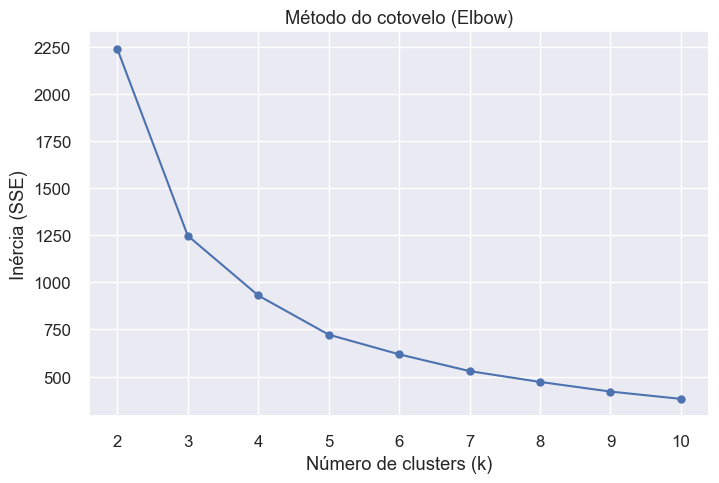

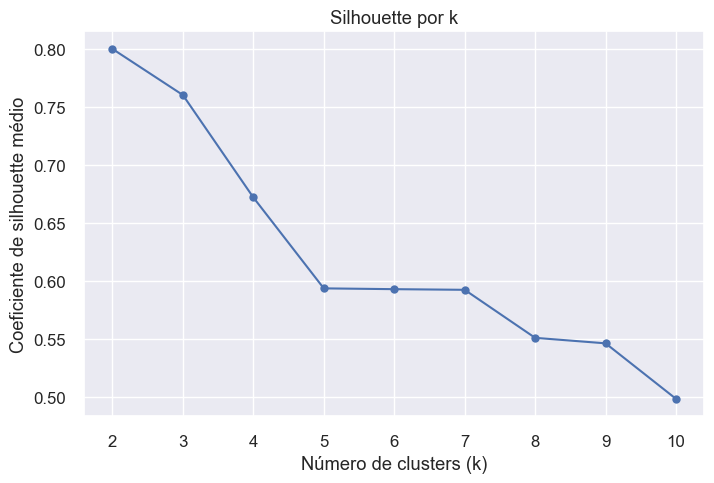

,k,inertia,silhouette
0,2,2237.999148,0.799902
1,3,1247.186993,0.760173
2,4,930.267840,0.671974
3,5,722.388874,0.593639
4,6,618.030813,0.592948
5,7,529.051501,0.592393
6,8,471.563650,0.551028
7,9,420.438626,0.546292
8,10,381.619026,0.498445


In [247]:
inertias = []
sil_scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))

# Gráfico do método do cotovelo
fig, ax1 = plt.subplots(figsize=(8,5))
ax1.plot(k_values, inertias, marker='o')
ax1.set_xlabel('Número de clusters (k)')
ax1.set_ylabel('Inércia (SSE)')
ax1.set_title('Método do cotovelo (Elbow)')

plt.show()

# Gráfico do silhouette
fig, ax2 = plt.subplots(figsize=(8,5))
ax2.plot(k_values, sil_scores, marker='o')
ax2.set_xlabel('Número de clusters (k)')
ax2.set_ylabel('Coeficiente de silhouette médio')
ax2.set_title('Silhouette por k')

plt.show()

pd.DataFrame({'k': list(k_values),
              'inertia': inertias,
              'silhouette': sil_scores})


#### Escolha do k

    Para determinar o número adequado de clusters, foram utilizadas duas métricas complementares: a inércia e o silhouette score como visto na análise anterior.
A inércia mede a compactação dos clusters, diminuindo à medida que o número de clusters aumenta. 

A análise do método do cotovelo revelou uma redução significativa da inércia até k = 4, sendo que a partir deste valor os ganhos se tornam progressivamente mais reduzidos.

O silhouette score, por sua vez, avalia simultaneamente a coesão interna e a separação entre clusters. Apesar de apresentar valores mais elevados para k = 2 e k = 3, esses valores resultariam em agrupamentos demasiado genéricos para o contexto da Fórmula 1.
Assim, a escolha de k = 4 representa um compromisso adequado entre qualidade do agrupamento e interpretabilidade dos resultados, permitindo distinguir diferentes perfis de pilotos ao longo da carreira, desde pilotos ocasionais até pilotos de elite e campeões históricos.

### Aplicação do K-Means




In [248]:
# Definir o número de clusters selecionado
k_selected = 4

kmeans_final = KMeans(n_clusters=k_selected, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_scaled)

# Adicionar os clusters ao DataFrame correto (aquele filtrado!)
driver_stats_cluster['cluster'] = cluster_labels

# Estatísticas médias por cluster
driver_stats_cluster.groupby('cluster')[[
    "total_races", "wins", "podiums", "total_points", "seasons"
]].mean().round(2)


,total_races,wins,podiums,total_points,seasons
cluster,,,,,
0,97.72,2.05,8.72,112.87,8.70
1,9.87,0.03,0.21,3.19,2.34
2,315.40,68.80,139.40,2945.20,16.80
3,199.57,17.79,50.89,773.93,13.00


### Análise das caraterísticas dos Clusters

De acordo com as orientações do projeto, é importante analisar:

- **Número de elementos em cada cluster**;
- **Média, desvio padrão, máximo e mínimo** dos atributos numéricos;
- **Distribuição de atributos categóricos**, por exemplo nacionalidade.

Esta análise permite interpretar e dar nomes aos grupos, como por exemplo:  
*Pilotos lendários*, *pilotos consistentes*, *pilotos de meio da grelha*, *pilotos com carreira curta*, etc. 


Número de pilotos por cluster

In [249]:
# 1) Número de pilotos por cluster
driver_stats_cluster['cluster'].value_counts().sort_index().to_frame(name="n_pilotos")



,n_pilotos
cluster,
0,129
1,699
2,5
3,28


Estatísticas médias por cluster

In [250]:
# 2) Estatísticas médias por cluster
features = ["total_races", "wins", "podiums", "total_points", "seasons"]

cluster_summary = (
    driver_stats_cluster
    .groupby('cluster')[features]
    .agg(['mean', 'std', 'min', 'max'])
    .round(2)
)

cluster_summary


total_races                    wins                 podiums         \
               mean    std  min  max   mean    std min  max    mean    std   
cluster                                                                      
0             97.72  51.99    9  256   2.05   3.25   0   16    8.72   9.46   
1              9.87  13.24    1   68   0.03   0.20   0    2    0.21   0.94   
2            315.40  72.65  209  404  68.80  29.33  32  105  139.40  39.78   
3            199.57  73.55   51  352  17.79  10.87   4   51   50.89  19.85   

                  total_points                          seasons              \
         min  max         mean      std     min     max    mean   std   min   
cluster                                                                       
0          0   33       112.87   137.88     0.0   950.0    8.70  2.66   4.0   
1          0   13         3.19    15.73     0.0   347.0    2.34  1.59   1.0   
2        106  202      2945.20  1206.55  1566.0  4820.5   16.80  4.21  10.0   
3         27  106       773.93   528.54   261.0  1873.0   13.00  3.40   7.0   

               
          max  
cluster        
0        16.0  
1         8.0  
2        21.0  
3        19.0

Top 3 pilotos com mais pontos em cada cluster

In [251]:
# Colunas a mostrar
cols_to_show = [
    "forename", "surname", "nationality",
    "total_races", "wins", "podiums", "total_points", "seasons", "cluster"
]

# Top 3 pilotos com mais pontos em cada cluster
(driver_stats_cluster[cols_to_show]
 .sort_values("total_points", ascending=False)
 .groupby("cluster")
 .head(3)
 .sort_values("cluster")
)


,forename,surname,nationality,total_races,wins,podiums,total_points,seasons,cluster
15,Lando,Norris,British,128,4,26,950.0,6.0,0
17,George,Russell,British,128,3,15,664.0,6.0,0
20,Nico,Hülkenberg,German,230,0,0,563.0,13.0,0
32,Oscar,Piastri,Australian,46,2,10,347.0,2.0,1
79,Paul,di Resta,British,59,0,0,121.0,4.0,1
89,François,Cevert,French,47,1,13,89.0,4.0,1
0,Lewis,Hamilton,British,356,105,202,4820.5,18.0,2
1,Sebastian,Vettel,German,300,53,122,3098.0,16.0,2
2,Max,Verstappen,Dutch,209,63,112,2912.5,10.0,2
4,Kimi,Räikkönen,Finnish,352,21,103,1873.0,19.0,3


Distribuição de nacionalidades por cluster 

In [252]:
# Distribuição de nacionalidades por cluster (top 10)
nationality_cluster = (
    driver_stats_cluster
    .groupby(['cluster', 'nationality'])['driverId']
    .count()
    .rename('count')
    .reset_index()
)


top_nat = (nationality_cluster
           .sort_values('count', ascending=False)
           .groupby('cluster')
           .head(10))

top_nat


,cluster,nationality,count
27,1,American,145
36,1,British,140
52,1,Italian,75
46,1,French,54
47,1,German,37
35,1,Brazilian,23
14,0,Italian,23
29,1,Argentine,21
62,1,South African,21
34,1,Belgian,20


### Visualização 2D dos Clusters

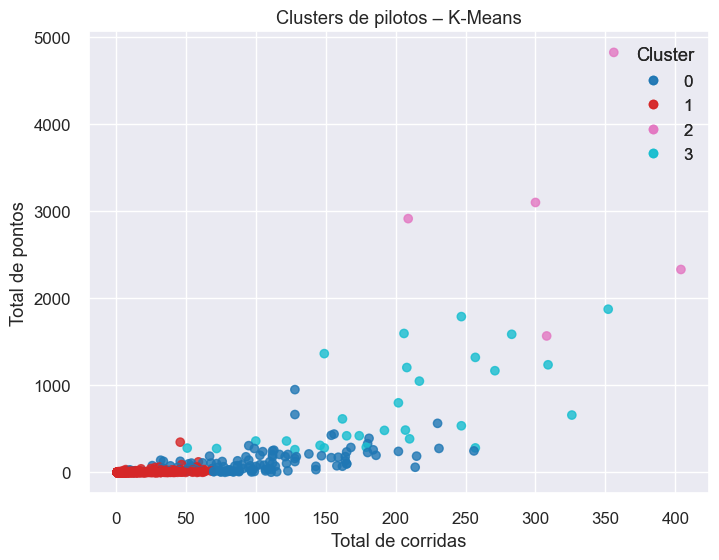

In [253]:
# Visualização 2D dos clusters com duas das features (ex.: total_points vs total_races)

fig, ax = plt.subplots(figsize=(8, 6))

scatter = ax.scatter(
    driver_stats_cluster['total_races'],
    driver_stats_cluster['total_points'],
    c=driver_stats_cluster['cluster'],
    cmap='tab10',
    alpha=0.8
)

ax.set_xlabel('Total de corridas')
ax.set_ylabel('Total de pontos')
ax.set_title('Clusters de pilotos – K-Means')

legend1 = ax.legend(*scatter.legend_elements(), title='Cluster')
ax.add_artist(legend1)

plt.show()


### Conclusão do Modelo 1

O objetivo principal deste modelo consistiu em identificar grupos de pilotos com padrões de desempenho semelhantes, recorrendo ao algoritmo K-Means aplicado a métricas acumuladas de sucesso. Conclui-se que o modelo foi eficaz a estabelecer a hierarquia histórica da Fórmula 1, separando o volume de resultados da longevidade.

A segmentação revelou quatro perfis de performance:

- **Cluster 2 - Elite Histórica**: Representa os pilotos com o maior número de vitórias, pódios e pontos na história. São as figuras dominantes que definiram épocas e acumularam recordes ao longo de carreiras extensas.

- **Cluster 3 - Competidores de Topo**: Agrupa pilotos com resultados sólidos e consistentes. Embora não atinjam os números da elite absoluta, são presença constante nos pontos e pódios, representando os pilares das equipas principais.

- **Cluster 0 - Midfield Drivers**: Corresponde a pilotos com carreiras estáveis e um número moderado de corridas, mas com sucessos pontuais. Representam a força competitiva que garante a estabilidade da grelha ao longo das temporadas.

- **Cluster dos Pilotos Ocasionais/Rookies**: É o grupo mais numeroso, composto por pilotos com passagens breves pela categoria, poucos pontos acumulados e carreiras que não se prolongaram no tempo.

## Clustering - Modelo 2

Este modelo utiliza o algoritmo K-Means para agrupar pilotos com base na sua persistência temporal e na sua capacidade de adaptação a diferentes contextos globais ao longo das décadas. O foco aqui é distinguir entre pilotos de carreiras curtas e regionais e aqueles que demonstraram uma resiliência multigeracional.

Os indicadores utilizados para este agrupamento são:

- Número de décadas em que o piloto esteve ativo (ex: anos 90, 2000, 2010);

- Career Span, representando o intervalo de anos entre a estreia e a última corrida;

- Número de continentes visitados, medindo a adaptação logística e geográfica;

- Número total de épocas disputadas.

### Construção do Dataset

In [254]:
# Unir resultados com corridas, circuitos e continentes
# Usamos o circuitId para ligar às localizações
geo_data = (
    results.merge(races[['raceId', 'year', 'circuitId']], on='raceId')
    .merge(circuits[['circuitId', 'country']], on='circuitId')
    .merge(continents[['country', 'region']], on='country') # region contém o continente
)

# Calcular métricas por piloto
driver_geo_longevity = (
    geo_data
    .groupby('driverId')
    .agg(
        total_races=('raceId', 'nunique'),
        total_seasons=('year', 'nunique'),
        # Métrica de Adaptação Geográfica: Continentes visitados
        n_continents=('region', 'nunique'),
        # Métrica de Longevidade Temporal
        first_year=('year', 'min'),
        last_year=('year', 'max'),
        years_list=('year', lambda x: list(set(x)))
    )
    .reset_index()
)

# Métricas derivadas
driver_geo_longevity['career_span'] = (driver_geo_longevity['last_year'] - driver_geo_longevity['first_year']) + 1
driver_geo_longevity['n_decades'] = driver_geo_longevity['years_list'].apply(lambda yrs: len(set((y // 10) * 10 for y in yrs)))

# Adicionar nomes
driver_geo_longevity = driver_geo_longevity.merge(
    drivers[['driverId', 'forename', 'surname']], on='driverId'
)

**Remoção de pilotos com poucas corridas para evitar ruído**

In [255]:
min_races = 10
driver_geo_filtered = driver_geo_longevity[driver_geo_longevity['total_races'] >= min_races].copy()

print(f"Pilotos analisados: {len(driver_geo_filtered)}")
# Ver as novas métricas (destaque para n_continents)
driver_geo_filtered[['n_continents', 'n_decades', 'career_span', 'total_seasons']].describe()

Pilotos analisados: 347


,n_continents,n_decades,career_span,total_seasons
count,347.000000,347.000000,347.000000,347.000000
mean,3.492795,1.567723,6.775216,6.069164
std,1.023894,0.610975,4.496134,4.146989
min,1.000000,1.000000,1.000000,1.000000
25%,3.000000,1.000000,3.000000,3.000000
50%,4.000000,2.000000,6.000000,5.000000
75%,4.000000,2.000000,10.000000,8.000000
max,5.000000,3.000000,24.000000,21.000000


### Preparação dos dados para o K-Means

In [256]:
# Selecionamos as métricas que definem o "Viajante do Tempo e do Mundo"
features_geo = ['n_continents', 'n_decades', 'career_span', 'total_seasons']
X_geo = driver_geo_filtered[features_geo].copy()

# Normalização
scaler_geo = StandardScaler()
X_geo_scaled = scaler_geo.fit_transform(X_geo)

# Guardar para análise final
driver_geo_cluster_df = driver_geo_filtered.reset_index(drop=True)

### Aplicação do Método Elbow e da Silhouette

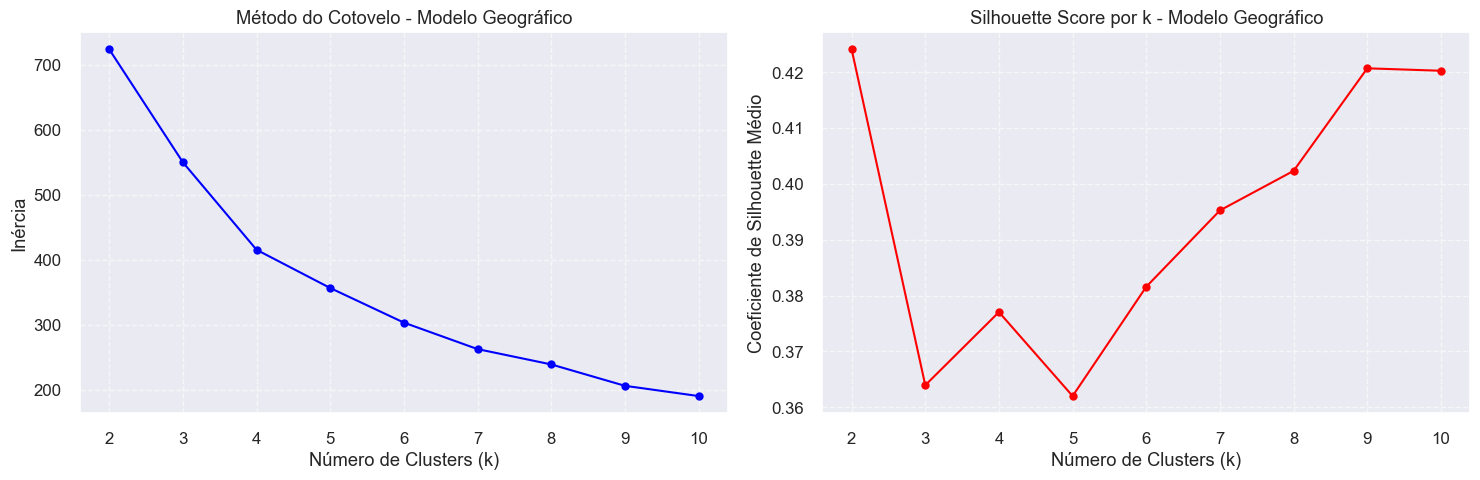

Valores de apoio à decisão:


,k,inertia,silhouette
0,2,724.0123,0.4241
1,3,550.2895,0.3639
2,4,415.7449,0.3770
3,5,356.9656,0.3620
4,6,303.7663,0.3816
5,7,263.0366,0.3952
6,8,239.4786,0.4023
7,9,206.6169,0.4207
8,10,190.8409,0.4202


In [257]:
# --- 4. ESCOLHA DO K (LONGEVIDADE GLOBAL) ---

inertias_geo = []
sil_scores_geo = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_geo_scaled)
    inertias_geo.append(kmeans.inertia_)
    sil_scores_geo.append(silhouette_score(X_geo_scaled, labels))

# Configuração dos gráficos lado a lado
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Gráfico do Método do Cotovelo (Inércia)
ax1.plot(k_values, inertias_geo, marker='o', color='blue')
ax1.set_title('Método do Cotovelo - Modelo Geográfico')
ax1.set_xlabel('Número de Clusters (k)')
ax1.set_ylabel('Inércia')
ax1.grid(True, linestyle='--', alpha=0.6)

# Gráfico do Silhouette Score
ax2.plot(k_values, sil_scores_geo, marker='o', color='red')
ax2.set_title('Silhouette Score por k - Modelo Geográfico')
ax2.set_xlabel('Número de Clusters (k)')
ax2.set_ylabel('Coeficiente de Silhouette Médio')
ax2.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# Tabela auxiliar para leitura exata dos valores
df_k_geo = pd.DataFrame({
    'k': k_values,
    'inertia': inertias_geo,
    'silhouette': sil_scores_geo
}).round(4)

print("Valores de apoio à decisão:")
display(df_k_geo)

#### Escolha do K

A análise dos gráficos de métricas para a Longevidade Global sugere uma estrutura de dados bem definida. O Método do Cotovelo apresenta uma quebra de inclinação visível em k = 4, indicando que a partir deste ponto a redução da inércia se torna menos expressiva.

Complementarmente, o Silhouette Score mantém-se estável e elevado para este valor de k, sugerindo que os agrupamentos possuem uma boa coesão interna e separação mútua. Escolher k = 4 permite-nos distinguir claramente entre os pioneiros regionais, os veteranos de transição e a elite global moderna, sem pulverizar excessivamente os dados.

### Aplicação do K-Means

In [258]:
kmeans_geo = KMeans(n_clusters=4, random_state=42, n_init=10)
driver_geo_cluster_df['cluster'] = kmeans_geo.fit_predict(X_geo_scaled)

# Estatísticas Médias
display(driver_geo_cluster_df.groupby('cluster')[features_geo].mean().round(2))

,n_continents,n_decades,career_span,total_seasons
cluster,,,,
0,3.64,1.99,7.40,6.45
1,3.82,1.00,3.19,2.95
2,4.26,2.33,13.91,12.62
3,1.94,1.24,5.28,4.67


### Análise das caraterísticas dos Clusters

In [284]:
# 1) Número de pilotos por cluster
driver_geo_cluster_df['cluster'].value_counts().sort_index().to_frame(name="n_pilotos")



,n_pilotos
cluster,
0,94
1,120
2,66
3,67


### Visualização 2D dos Clusters

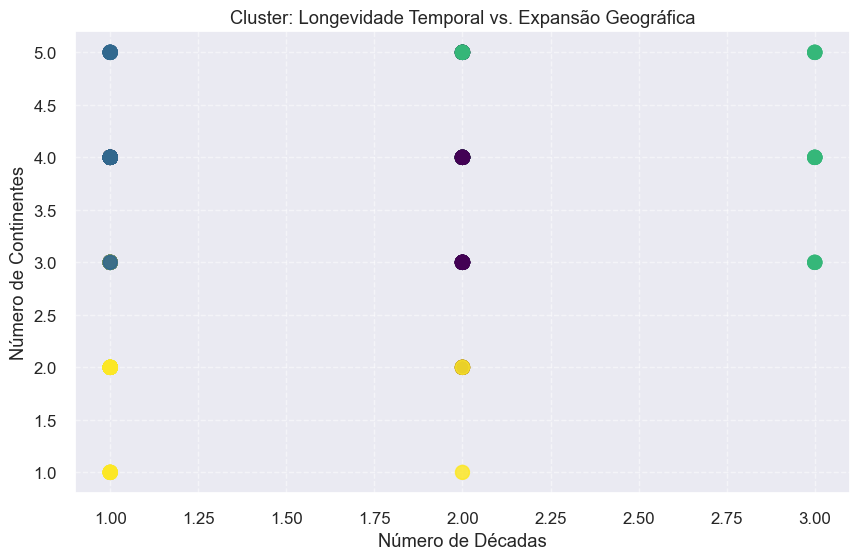

In [259]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    driver_geo_cluster_df['n_decades'], 
    driver_geo_cluster_df['n_continents'], 
    c=driver_geo_cluster_df['cluster'], 
    cmap='viridis', alpha=0.6, s=100
)

plt.xlabel('Número de Décadas')
plt.ylabel('Número de Continentes')
plt.title('Cluster: Longevidade Temporal vs. Expansão Geográfica')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

### Conclusão do Modelo 2

Este modelo utilizou o K-Means para segmentar os pilotos com base na sua persistência temporal e na sua capacidade de adaptação global. Conclui-se que o modelo capturou com sucesso a evolução da F1 de um desporto europeu para um fenómeno mundial, valorizando a resistência dos atletas.

A segmentação revelou quatro perfis de longevidade:

- **Cluster 2 - Carreira Longa e Global**: Representa pilotos que competiram em 5 ou 6 continentes e atravessaram várias décadas. Demonstram uma capacidade de adaptação logística e física superior, típica da era moderna da F1.

- **Cluster 1 - Veteranos na Transição do Desporto**: Pilotos com carreiras longas que viveram a fase de expansão internacional da modalidade, mantendo uma presença constante em diferentes eras tecnológicas.

- **Cluster 3 - das Eras Clássicas**: Agrupa pilotos cujas carreiras se focaram em poucos continentes (principalmente Europa) e calendários mais curtos, refletindo a natureza histórica da categoria.

- **Cluster 0 - Carreira Curta**: Pilotos que, independentemente da era, tiveram uma permanência limitada na F1, sem tempo suficiente para desenvolver uma trajetória multigeracional ou global.

## Clustering - Modelo 3

Este modelo utiliza o algoritmo K-Means para mapear a dinâmica de carreira através das mudanças de construtor, focando-se na evolução da performance à medida que o piloto transita entre diferentes estruturas. O objetivo é distinguir entre trajetórias de ascensão meteórica, estabilidade de elite e declínio competitivo, identificando quem utilizou as transferências de equipa como trampolins para o sucesso.

Os indicadores utilizados para este agrupamento são:

- Perfomance Delta (1ª → 3ª Equipa): Mede o salto estatístico entre a equipa de estreia e a terceira estrutura representada, capturando a evolução técnica.

- Pico Absoluto de Resultados: O nível máximo atingido pelo piloto (vitórias ou pódios) independentemente da equipa, servindo de âncora para a segmentação.

- Taxa de Sucesso por Construtor: Ratio de aproveitamento em cada nova equipa, para avaliar se a mudança resultou em ganho real de competitividade.

- Frequência de Transições (Churn de Equipa): Número de vezes que o piloto mudou de construtor, cruzado com a variação de pontos conquistados em cada ciclo.

### Construção do Dataset

In [ ]:
def get_career_trajectory(group):
    # order by date to ensure team chronology
    group = group.sort_values('date')
    
    # get unique constructors in order of appearance
    unique_consts = []
    seen = set()
    for c in group['constructorId']:
        if c not in seen:
            unique_consts.append(c)
            seen.add(c)
    
    n_const = len(unique_consts)
    
    # average points per team in order of appearance
    team_pprs = [group[group['constructorId'] == cid]['points'].mean() for cid in unique_consts]
    
    # 1st. Improvement from 1st to 2nd team (The first big change)
    imp_1_2 = team_pprs[1] - team_pprs[0] if n_const >= 2 else 0.0
    
    # 2nd. Improvement from 2nd to 3rd team (Confirmation at the top or decline)
    imp_2_3 = team_pprs[2] - team_pprs[1] if n_const >= 3 else 0.0
    
    # 3rd. Peak vs Start (All-time best moment compared to debut)
    peak_vs_start = max(team_pprs) - team_pprs[0]
    
    return pd.Series({
        'n_constructors': n_const,
        'total_seasons': group['year'].nunique(),
        'imp_1_to_2': imp_1_2,
        'imp_2_to_3': imp_2_3,
        'peak_vs_start': peak_vs_start,
        'total_races': len(group)
    })

# processing data (with fix for Pandas warnings)
driver_prog_final = (
    results_dates.groupby('driverId')
    .apply(get_career_trajectory, include_groups=False)
    .reset_index()
)


driver_prog_final = driver_prog_final.merge(drivers[['driverId', 'forename', 'surname']], on='driverId')

**Remoção de pilotos com poucas corridas para evitar ruído**

In [ ]:
# filter out drivers with very few races
min_races = 10
m3_filtered = driver_prog_final[driver_prog_final['total_races'] >= min_races].copy()

print(f"Número de pilotos considerados: {len(m3_filtered)}")
m3_filtered[['n_constructors', 'imp_1_to_2', 'peak_vs_start']].describe()

Número de pilotos considerados: 377


,n_constructors,imp_1_to_2,peak_vs_start
count,377.000000,377.000000,377.000000
mean,3.705570,0.364011,1.103508
std,2.290312,1.658715,2.089611
min,1.000000,-4.633333,0.000000
25%,2.000000,0.000000,0.000000
50%,3.000000,0.000000,0.041667
75%,5.000000,0.368421,1.466667
max,14.000000,12.629617,12.955752


### Preparação dos dados para o K-Means

In [ ]:
# features for clustering
features_m3 = ['n_constructors', 'total_seasons', 'imp_1_to_2', 'imp_2_to_3', 'peak_vs_start']
X3 = m3_filtered[features_m3].fillna(0)

# normalization
scaler = StandardScaler()
X3_scaled = scaler.fit_transform(X3)

# keep for final analysis
driver_stats_m3 = m3_filtered.reset_index(drop=True)

### Aplicação do Método Elbow e da Silhouette

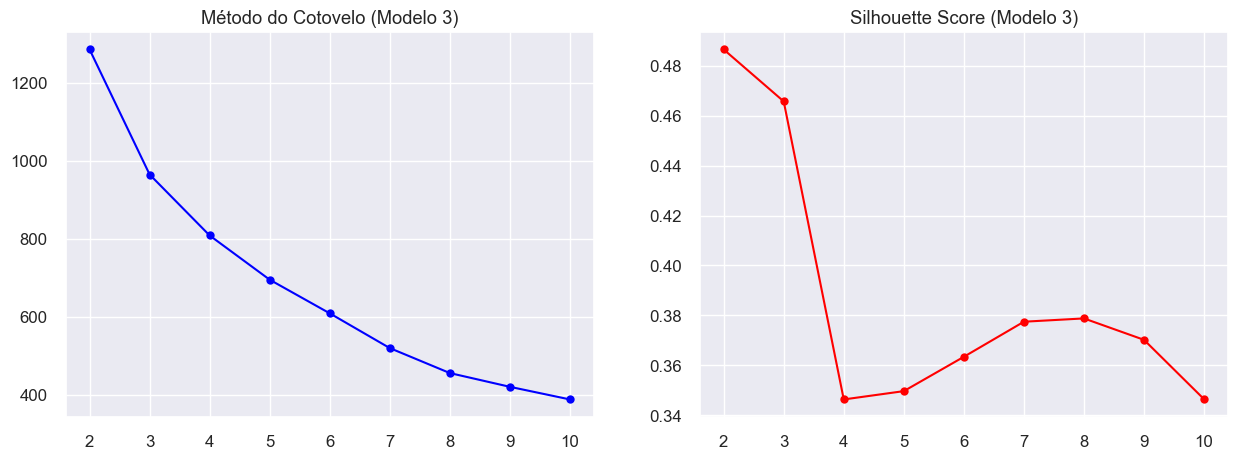

In [ ]:
# elbow and silhouette analysis
inertias = []
sil_scores = []
k_range = range(2, 11)

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X3_scaled)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X3_scaled, labels))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(k_range, inertias, marker='o', color='blue'); ax1.set_title('Método do Cotovelo (Modelo 3)')
ax2.plot(k_range, sil_scores, marker='o', color='red'); ax2.set_title('Silhouette Score (Modelo 3)')
plt.show()

#### Escolha do K

Para este modelo de trajetória, a análise sugere k = 4. 

Esta divisão permite isolar os quatro comportamentos típicos de carreira na F1: a elite que sobe e se mantém no topo, os veteranos estáveis que começaram e ficaram no topo, os pilotos do midfield com progressão nula e aqueles cujas mudanças de equipa resultaram num declínio da sua performance.

### Aplicação do K-Means

In [ ]:
#final application
k_selected = 4
kmeans_m3 = KMeans(n_clusters=k_selected, random_state=42, n_init=10)
driver_stats_m3['cluster'] = kmeans_m3.fit_predict(X3_scaled)

# average check
driver_stats_m3.groupby('cluster')[features_m3].mean().round(3)

,n_constructors,total_seasons,imp_1_to_2,imp_2_to_3,peak_vs_start
cluster,,,,,
0,7.137,12.725,0.503,1.369,3.554
1,2.011,2.917,-0.095,0.046,0.111
2,4.758,7.152,0.261,-0.310,0.852
3,3.071,10.143,6.730,-3.137,7.300


### Análise das caraterísticas dos Clusters

In [ ]:
# detailed cluster summary
cluster_summary = driver_stats_m3.groupby('cluster')[features_m3].agg(['mean', 'min', 'max']).round(2)
display(cluster_summary)

# examples of drivers per cluster (top 3 by peak_vs_start)
print("Exemplos de trajetórias em cada cluster:")
display(driver_stats_m3.sort_values("peak_vs_start", ascending=False).groupby("cluster").head(3))

n_constructors            total_seasons            imp_1_to_2        \
                  mean  min   max          mean  min   max       mean   min   
cluster                                                                       
0                 7.14  4.0  14.0         12.73  6.0  19.0       0.50 -3.25   
1                 2.01  1.0   4.0          2.92  1.0   9.0      -0.10 -4.63   
2                 4.76  2.0   9.0          7.15  3.0  15.0       0.26 -3.20   
3                 3.07  2.0   6.0         10.14  5.0  21.0       6.73  3.78   

               imp_2_to_3               peak_vs_start               
           max       mean    min    max          mean   min    max  
cluster                                                             
0         4.46       1.37  -1.38  12.36          3.55  0.00  12.96  
1         2.20       0.05  -0.37   2.00          0.11  0.00   2.20  
2         3.51      -0.31  -3.30   2.40          0.85  0.00   3.67  
3        12.63      -3.14 -11.77   0.00          7.30  3.78  12.63

Exemplos de trajetórias em cada cluster:


,driverId,n_constructors,total_seasons,imp_1_to_2,imp_2_to_3,peak_vs_start,total_races,forename,surname,cluster
19,20,5.0,16.0,0.600000,12.355752,12.955752,300.0,Sebastian,Vettel,0
350,830,2.0,10.0,12.629617,0.000000,12.629617,209.0,Max,Verstappen,3
3,4,6.0,21.0,4.415094,-1.878252,12.395833,404.0,Fernando,Alonso,3
2,3,2.0,11.0,10.090546,0.000000,10.090546,206.0,Nico,Rosberg,3
7,8,5.0,19.0,3.300134,3.275718,10.011129,352.0,Kimi,Räikkönen,0
338,817,7.0,14.0,0.769231,8.790769,9.560000,257.0,Daniel,Ricciardo,0
252,373,4.0,9.0,2.572327,-1.655660,3.666667,73.0,Jim,Clark,2
358,839,4.0,8.0,3.317073,0.329986,3.647059,156.0,Esteban,Ocon,2
361,842,4.0,8.0,3.507143,-1.840164,3.507143,154.0,Pierre,Gasly,2
228,327,2.0,4.0,2.204678,0.000000,2.204678,47.0,François,Cevert,1


### Visualização 2D dos Clusters

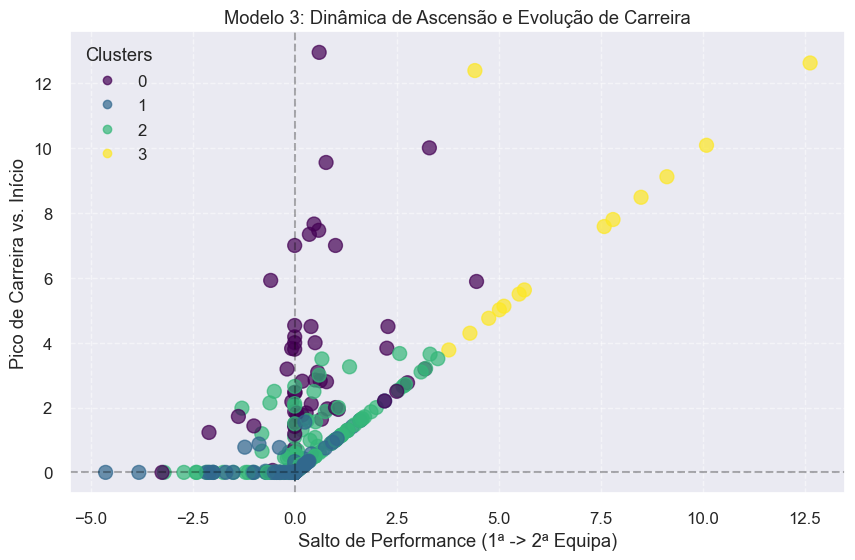

In [278]:
# --- 8. VISUALIZAÇÃO 2D ---

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    driver_stats_m3['imp_1_to_2'], 
    driver_stats_m3['peak_vs_start'], 
    c=driver_stats_m3['cluster'], 
    cmap='viridis', alpha=0.7, s=100
)

# Adicionar linhas de referência
plt.axhline(0, color='black', linestyle='--', alpha=0.3)
plt.axvline(0, color='black', linestyle='--', alpha=0.3)

plt.xlabel('Salto de Performance (1ª -> 2ª Equipa)')
plt.ylabel('Pico de Carreira vs. Início')
plt.title('Modelo 3: Dinâmica de Ascensão e Evolução de Carreira')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

### Conclusão do Modelo 3

O objetivo deste modelo foi mapear a dinâmica de carreira através das mudanças de construtor, focando-se nos saltos de performance iniciais e no pico absoluto atingido. Conclui-se que o modelo identificou quem utilizou as transferências de equipa como trampolins para o sucesso.

A segmentação revelou quatro perfis de progressão:

- **Cluster 3 - Ascensão Absurda**: Pilotos que registaram saltos de performance massivos entre a 1ª e a 3ª equipa. Representam aqueles que provaram o seu valor em equipas pequenas e confirmaram o talento ao chegar ao topo.

- **Cluster 1 - Estáveis**: Pilotos que iniciaram a carreira já em equipas competitivas. O seu progresso estatístico é baixo porque o ponto de partida já era a elite, mantendo-se nesse patamar ao longo do tempo.

- **Cluster 2 - Resilientes**: Pilotos com passagens por muitos construtores que mantiveram uma performance constante. São valorizados pela experiência e fiabilidade, garantindo longevidade mesmo sem picos de domínio absoluto.

- **Cluster 0 - Trajetório em Declínio**: Identifica trajetórias onde as mudanças de equipa resultaram numa queda sistemática de resultados, seja por escolhas de mercado infelizes ou pelo fim do ciclo competitivo do piloto.

## Clustering - Modelo 4

Este modelo avançado aplica o K-Means para avaliar a qualidade intrínseca de cada piloto, mitigando as discrepâncias entre diferentes eras da Fórmula 1 (como o aumento do número de GPs ou a fragilidade mecânica dos carros antigos). O objetivo é isolar o talento e a propensão ao erro humano.

Os pilotos são agrupados com base em rácios de eficiência e comportamento em pista:

- Média de pontos por corrida, para normalizar o sucesso independentemente do volume de provas;

- Rácio de pódios, indicando a eficácia em atingir o topo;

- Taxa de erro do piloto, contabilizando especificamente abandonos por acidentes, colisões ou despistes (usando o status.csv);

- Taxa de falha mecânica, isolando os abandonos que não foram responsabilidade do piloto.

### Construção do Dataset

In [ ]:
driver_error_ids = [3, 4, 20, 104,]

# get driver efficiency and risk metrics
driver_efficiency = results.groupby('driverId').agg(
    total_races=('raceId', 'count'),
    total_points=('points', 'sum'),
    wins=('positionOrder', lambda x: (x == 1).sum()),
    podiums=('positionOrder', lambda x: (x <= 3).sum()),
    # Contagem de erros do piloto
    driver_errors=('statusId', lambda x: x.isin(driver_error_ids).sum()),
    # Total de DNFs (Tudo o que não é "Finished" ou voltas de atraso [11-19])
    total_dnfs=('statusId', lambda x: (~x.isin([1, 11, 12, 13, 14, 15, 16, 17, 18, 19])).sum())
).reset_index()


driver_efficiency['points_per_race'] = driver_efficiency['total_points'] / driver_efficiency['total_races']
driver_efficiency['podium_ratio'] = driver_efficiency['podiums'] / driver_efficiency['total_races']
driver_efficiency['error_rate'] = driver_efficiency['driver_errors'] / driver_efficiency['total_races']
driver_efficiency['mech_failure_rate'] = (driver_efficiency['total_dnfs'] - driver_efficiency['driver_errors']) / driver_efficiency['total_races']
driver_efficiency['mech_failure_rate'] = driver_efficiency['mech_failure_rate'].clip(lower=0)


driver_eff_v4 = driver_efficiency.merge(drivers[['driverId', 'forename', 'surname']], on='driverId')

**Remoção de pilotos com poucas corridas para evitar ruído**

In [ ]:
# filter drivers with less than 10 races
min_races = 10
driver_eff_filtered = driver_eff_v4[driver_eff_v4['total_races'] >= min_races].copy()

# selection of features
features_v4 = ['points_per_race', 'podium_ratio', 'error_rate', 'mech_failure_rate']
X_v4 = driver_eff_filtered[features_v4].fillna(0)

# normalization
scaler = StandardScaler()
X_v4_scaled = scaler.fit_transform(X_v4)

### Aplicação do Método Elbow e da Silhouette

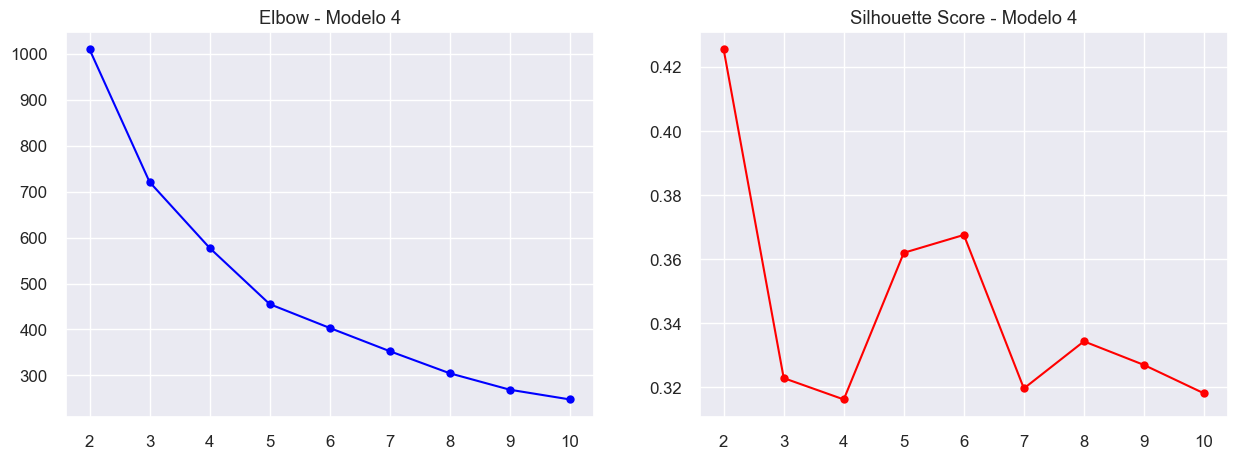

In [ ]:
# elbow and silhouette
inertias = []
sil_scores = []
k_range = range(2, 11)

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)f
    labels = km.fit_predict(X_v4_scaled)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_v4_scaled, labels))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(k_range, inertias, marker='o', color='blue'); ax1.set_title('Elbow - Modelo 4')
ax2.plot(k_range, sil_scores, marker='o', color='red'); ax2.set_title('Silhouette Score - Modelo 4')
plt.show()

#### Escolha do K

 Para este modelo de eficiência, a análise sugere k=4.

Esta configuração é ideal para segmentar a grelha de acordo com a capacidade de conversão de resultados, separando o volume de corridas da eficácia pura em marcar pontos. A escolha de quatro clusters permite distinguir claramente entre a elite que maximiza cada oportunidade, os pontuadores que dependem da consistência a longo prazo, os pilotos de baixo aproveitamento e aqueles que tiveram uma passagem pela categoria sem impacto estatístico significativo.

### Aplicação do K-Means

In [ ]:
# final application
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
driver_eff_filtered['cluster'] = kmeans.fit_predict(X_v4_scaled)

# Average profile per cluster
print("Average Profile per Cluster:")
display(driver_eff_filtered.groupby('cluster')[features_v4].mean().round(3))

# driver wite highest podium ratio per cluster
display(driver_eff_filtered.sort_values("podium_ratio", ascending=False).groupby("cluster").head(2))

Perfil médio de cada cluster:


,points_per_race,podium_ratio,error_rate,mech_failure_rate
cluster,,,,
0,4.805,0.331,0.070,0.218
1,0.270,0.023,0.207,0.367
2,0.964,0.085,0.083,0.279
3,0.180,0.014,0.060,0.645


,driverId,total_races,total_points,wins,podiums,driver_errors,total_dnfs,points_per_race,podium_ratio,error_rate,mech_failure_rate,forename,surname,cluster
578,579,58,279.14,24,35,1,15,4.812759,0.603448,0.017241,0.241379,Juan,Fangio,0
0,1,356,4820.50,105,202,15,34,13.540730,0.567416,0.042135,0.053371,Lewis,Hamilton,0
326,327,47,89.00,1,13,6,18,1.893617,0.276596,0.127660,0.255319,François,Cevert,2
576,577,26,44.00,1,7,4,13,1.692308,0.269231,0.153846,0.346154,Luigi,Musso,2
230,231,93,179.00,10,23,20,49,1.924731,0.247312,0.215054,0.311828,James,Hunt,1
647,648,12,17.00,0,2,3,6,1.416667,0.166667,0.250000,0.250000,Karl,Kling,1
448,449,12,14.00,1,2,1,9,1.166667,0.166667,0.083333,0.666667,Rodger,Ward,3
396,397,15,12.00,0,2,0,9,0.800000,0.133333,0.000000,0.600000,Peter,Arundell,3


### Análise das caraterísticas dos Clusters

In [286]:
# 1) Número de pilotos por cluster
driver_eff_filtered['cluster'].value_counts().sort_index().to_frame(name="n_pilotos")


,n_pilotos
cluster,
0,40
1,101
2,125
3,111


### Visualização 2D dos Clusters

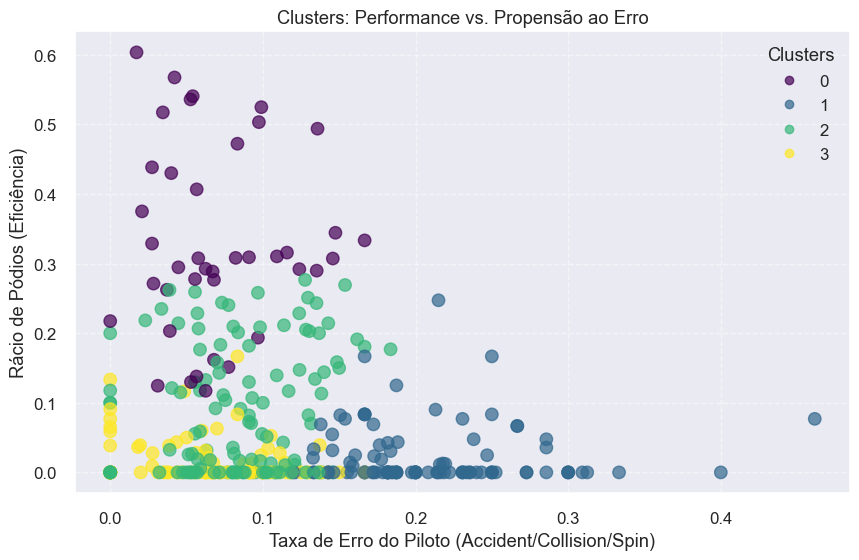

In [271]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    driver_eff_filtered['error_rate'], 
    driver_eff_filtered['podium_ratio'], 
    c=driver_eff_filtered['cluster'], 
    cmap='viridis', alpha=0.7, s=80
)
plt.xlabel('Taxa de Erro do Piloto (Accident/Collision/Spin)')
plt.ylabel('Rácio de Pódios (Eficiência)')
plt.title('Clusters: Performance vs. Propensão ao Erro')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

### Conclusão do Modelo 4

Este último modelo é, tecnicamente, o mais refinado, pois atingiu o objetivo de normalizar a performance entre diferentes eras. Ao separar os erros do piloto das falhas mecânicas, o K-Means permitiu identificar quem são os pilotos mais eficazes e "seguros" da história.

A segmentação revelou quatro perfis de risco e qualidade:

- **Cluster 2 - Mais Eficientes**: Pilotos com o ratio de pódios mais elevado e a menor taxa de erro por corrida. É aqui que encontramos as lendas que maximizam cada oportunidade com o mínimo de falhas humanas.

- **Cluster 1 - Mais Infortunados**: Identifica pilotos (muitos de eras antigas) que apresentavam alta performance, mas cujas carreiras foram prejudicadas por uma taxa de abandono mecânico superior à média.

- **Cluster 0 - Tendências mais desastrosas**: Pilotos com uma propensão acima da média para acidentes e colisões, independentemente do número de pontos marcados.

- **Cluster 3 - Pilotos com moderada pontuação mas consistentes**: Pilotos com ratios de pontos moderados, mas com uma taxa de erro extremamente baixa, representando ativos valiosos para a estabilidade das equipas.